In [14]:
import sys
sys.path.append("../")

from model import get_node_community_map
import networkx as nx
import numpy as np
import pickle


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})

plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [2]:
def sda_prob(d, a=8, b=3):
    return 1 / (1 + ((1/b)*d)**a)

def build_graph(P, W):
    G = nx.Graph()
    for i in range(8):
        G.add_node(W[i])
        
    coin_flips = np.random.uniform(size=780625)
    k = 0
    for i in range(len(P)):
        for j in range(i+1, len(P)):
            if P[i][j] > coin_flips[k]:
                G.add_edge(W[i], W[j])
            k += 1
            
    return G


W = np.random.normal(1, 0.02, size=8).round(3)
pairwise_distances = []
for i in range(len(W)):
    for j in range(i+1, len(W)):
        pairwise_distances.append(np.abs(W[i]-W[j]))


mean_dist = np.mean(pairwise_distances)
a = 2
b = mean_dist / 2

prob_attach = np.zeros((8,8))
k=0
for i in range(len(W)):
    for j in range(i+1,len(W)):
        p = sda_prob(pairwise_distances[k], a=a, b=b)
        prob_attach[i][j] = p
        prob_attach[j][i] = p
        k+=1
G3 = build_graph(prob_attach, W)

# ensure that graph is connected
connected_components = list(nx.connected_components(G))
largest_component = list(connected_components[0])

largest_component_wealths = W[np.array(largest_component)]

for i in range(1, len(connected_components)):
    comp = list(connected_components[i])
    node = np.random.choice(comp)
    closest_largest_component_node = (np.abs(largest_component_wealths - W[node])).argmin()
    G3.add_edge(W[node], W[largest_component[closest_largest_component_node]])

NameError: name 'G' is not defined

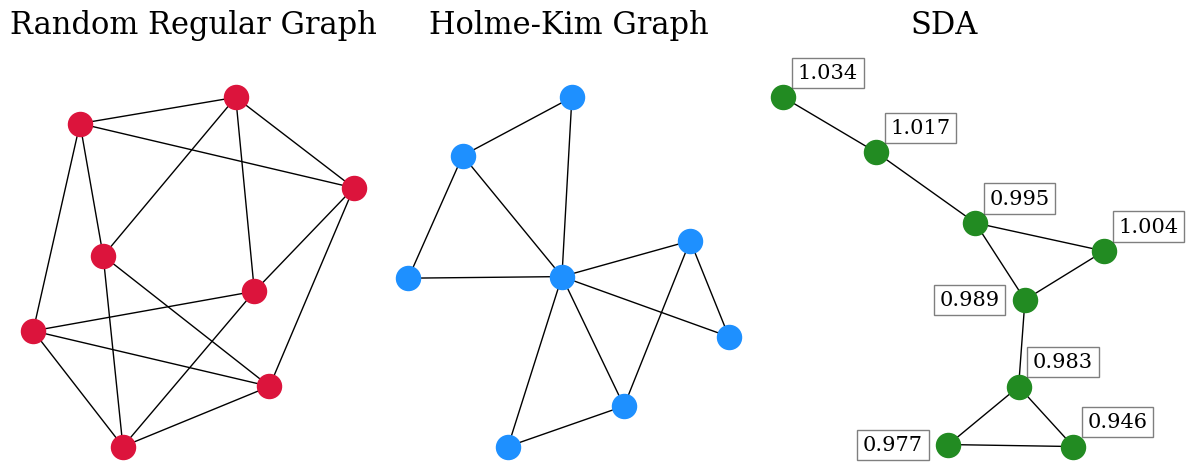

In [165]:
N = 8
#G1 = nx.random_regular_graph(n=N, d=4)
#G2 = nx.powerlaw_cluster_graph(n=N, m=2, p=0.5)

colors = ["crimson", "dodgerblue", "forestgreen"]

titles = ["Random Regular Graph", "Holme-Kim Graph", "SDA"]

fig, axs = plt.subplots(1,3, figsize=(12,5))
nx.draw_kamada_kawai(G1, ax=axs[0], node_color=colors[0])
axs[0].set_title(titles[0], y=1.1, fontsize=22)
nx.draw_kamada_kawai(G2, ax=axs[1], node_color=colors[1])
axs[1].set_title(titles[1], y=1.1, fontsize=22)

#pos = nx.spring_layout(G3)

for node in pos:
    x,y = pos[node]
    if node > 1.01 or node in [0.995, 1.004, 0.946, 0.983]:
        axs[2].text(x+0.08,y+0.1, s=node, bbox=dict(facecolor='white', alpha=0.5), horizontalalignment='center')
    else:
        axs[2].text(x-0.1,y-0.03, s=node, bbox=dict(facecolor='white', alpha=0.5), horizontalalignment='center')

nx.draw(G3, ax=axs[2], pos=pos, node_color=colors[2])
axs[2].set_title(titles[2], y=1.1, fontsize=22)

fig.tight_layout()
plt.savefig("../figures/sample_graphs.pdf", bbox_inches="tight")

In [3]:
from utils import construct_sda_graph

In [51]:
w = np.random.normal(10, 1, size=15)
G = construct_sda_graph(w, alpha=8)

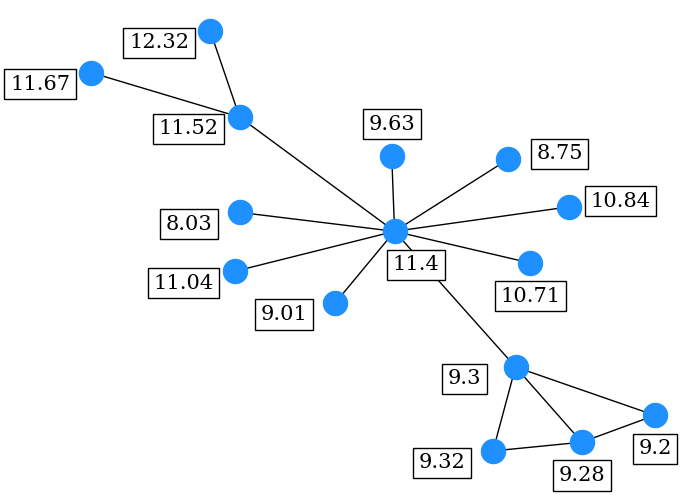

In [111]:
# pos = nx.spring_layout(G)

for node in pos:
    x,y = pos[node]
    
    val = w[node].round(2)
    
    if val in [12.32, 11.67, 11.52, 8.03, 11.04, 9.01, 9.3, 9.32]:
        x -= 0.12
        y -= 0.08
        
    elif val in [8.75, 10.84]:
        x += 0.12
    
    elif val in [9.28, 9.2, 10.71]:
        y -= 0.18
    
    elif val in [9.63]:
        y += 0.12
        
    elif val in [11.4]:
        y -= 0.18
        x += 0.05
    
    plt.text(x, y, s=val, 
             bbox=dict(facecolor='w', alpha=1), 
             horizontalalignment='center')

nx.draw(G, pos=pos, node_color="dodgerblue")

plt.savefig("sda_graph.pdf", bbox_inches="tight")

___

2 3.9936 159
267
1 6.202247191011236 146
4 4.0 4
327
5 9.45565749235474 31


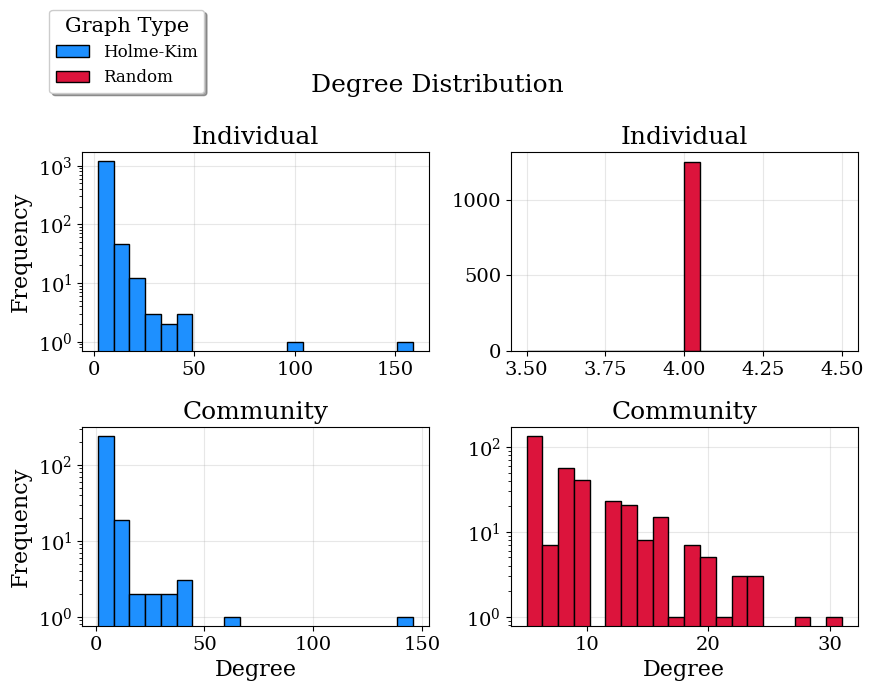

In [166]:
fig, axs = plt.subplots(2, 2, figsize=(9,6))

colors = ["dodgerblue", "crimson"]
titles = ["Holme-Kim", "Random"]

num_bins = 20


for g_idx, file in enumerate(["../graph.pickle", "../random_graph.pickle"]):

    with open(file, "rb") as f:
        G = pickle.load(f)
        
    # plot individual degree distribution
    degrees = list(dict(G.degree).values())
    print(min(degrees), np.mean(degrees), max(degrees))
    axs[0][g_idx].hist(degrees, color=colors[g_idx], edgecolor="k", bins=num_bins, label=titles[g_idx])
    if g_idx == 0:
        axs[0][g_idx].set_yscale("log")
    axs[0][g_idx].set_title("Individual")
    axs[1][g_idx].set_xlabel("Degree")
    axs[0][0].set_ylabel("Frequency")
    axs[1][0].set_ylabel("Frequency")


    communities = list(nx.community.label_propagation_communities(G))
    print(len(communities))
    adjacency = dict((n, set(nbrdict.keys())) for n, nbrdict in G.adjacency())
    node_community_map = get_node_community_map(communities)

    community_adjacency = {}
    for i,c in enumerate(communities):
        community_adjacency[i] = set()
        for node in c:
            node_neighbours = adjacency[node]
            for neighbour in node_neighbours:
                neighbouring_community = node_community_map[neighbour]
                if neighbouring_community != i:
                    community_adjacency[i].add(neighbouring_community)
            
    # plot community degree distribution
    comm_degrees = [len(x) for x in list(community_adjacency.values())]
    print(min(comm_degrees), np.mean(comm_degrees), max(comm_degrees))
    axs[1][g_idx].hist(comm_degrees, edgecolor="k", bins=num_bins, color=colors[g_idx])
    axs[1][g_idx].set_yscale("log")
    axs[1][g_idx].set_title("Community")
    

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, bbox_to_anchor=(0.25,1.17), prop={'size': 12}, shadow=True, title="Graph Type")
fig.tight_layout()
plt.suptitle("Degree Distribution", y=1.05)
plt.savefig("../figures/hk_random_graphs_degrees.pdf", bbox_inches="tight")
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(9,3))

colors = ["dodgerblue", "crimson"]
titles = ["Holme-Kim", "Random"]

num_bins = 20


for g_idx, file in enumerate(["../augmented_communities.pickle", "../augmented_communities_random.pickle"]):

    with open(file, "rb") as f:
        comms = pickle.load(f)
        
    community_sizes = [len(x) for x in list(comms.values())]
    community_sizes.remove(1250)
    print(np.min(community_sizes), np.mean(community_sizes), np.max(community_sizes))
    axs[g_idx].hist(community_sizes, 
                    label=titles[g_idx], 
                    color=colors[g_idx],
                    edgecolor="k",
                    bins=20)
    axs[g_idx].set_yscale("log")
    axs[g_idx].set_xlabel("Community Size")
    axs[0].set_ylabel("Frequency")
    

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, bbox_to_anchor=(0.28,1.34), prop={'size': 12}, shadow=True, title="Graph Type")
fig.tight_layout()
plt.suptitle("Community Size Distribution", y=1.1)
plt.savefig("../figures/hk_random_graphs_comm_sizes.pdf", bbox_inches="tight")
plt.show()